# Load & Visualize Images

In [1]:
import os
import sys

PROJECT_DIR="/mnt/workspace/__ing/cving/brain-tumor-detection"
sys.path.append(PROJECT_DIR)

from utils.utils import initialize_env_variables
from utils.image import (load_images, visualize_image, count_images,
                         CLASS_2_ID_DICT, ID_2_CLASS_DICT)
import utils.torch
from utils.validation import create_confusion_matrix, plot_confusion_matrix

from torch.utils.data import DataLoader

initialize_env_variables()

# # Example usage
# n_imgs_dict = {
#     "notumor": 1,
#     "pituitary": 1,
#     "meningioma": 1,
#     "glioma": 1,
# }
# data_dir = os.path.join(
#     PROJECT_DIR,
#     "data"
# )
# image_data = load_images(data_dir, "Training", seed=None, **n_imgs_dict)

# # Print the result
# for image_data_item in image_data:
#     tensor, label, image_name = image_data_item
#     print(f"Image: {image_name}, Label: {label}, Tensor shape: {tensor.shape}")
#     visualize_image(image_data_item)

Initialized environment variables listed in: /mnt/workspace/__ing/cving/brain-tumor-detection/.env


# Base Model

In [2]:
data_dir = os.path.join(
    PROJECT_DIR,
    "data"
)
data_dir

'/mnt/workspace/__ing/cving/brain-tumor-detection/data'

In [3]:
## Create Datasets:
train_val_dataset, test_dataset = utils.torch.prepare_datasets(
    data_dir=data_dir, is_vit=False
)

train_dataset, val_dataset = train_val_dataset.train_val_split(
    train_perc=0.8, seed=42
)

In [4]:
## Create Loaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
retrain = False
model = utils.torch.SimpleCNN()

model_path = os.path.join(
    PROJECT_DIR,
    "models",
    "base_model",
    "base_model.pth",
)

if os.path.exists(model_path) and not retrain:
    model.load_state_dict(
        utils.torch.load_model(model_path)
    )
    model.eval()
else:
    model = utils.torch.train_model(
        model, train_loader, val_loader, epochs=10, learning_rate=0.001)
    utils.torch.save_model(model, model_path)

## Error Analysis

In [6]:
misclassified_images = utils.torch.get_misclassified_images(
    model, val_loader, n_error=3, device="cpu", return_tensors=False
)

  0%|          | 0/36 [00:00<?, ?it/s]

Image: Tr-me_0143.jpg, Label: meningioma, Pred: glioma


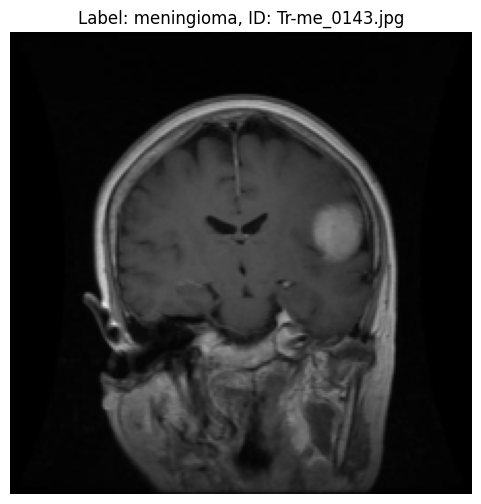

Image: Tr-me_1222.jpg, Label: meningioma, Pred: glioma


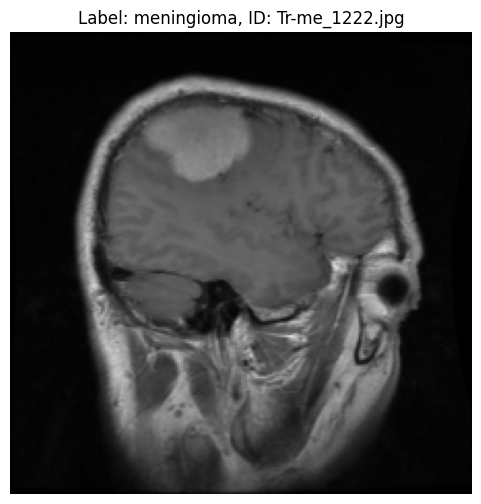

Image: Tr-no_0382.jpg, Label: notumor, Pred: meningioma


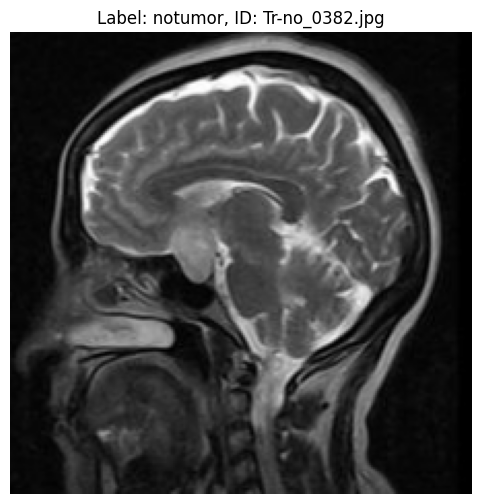

In [7]:
for misclassified_image in misclassified_images:
    label, image_name, pred = misclassified_image
    print(f"Image: {image_name}, Label: {label}, Pred: {pred}")
    image_data = load_images(data_dir, "Training", [image_name], seed=None)[0]
    visualize_image(image_data)

In [8]:
val_misclassified_images = utils.torch.get_misclassified_images(
    model, val_loader, device="cpu"
)
train_misclassified_images = utils.torch.get_misclassified_images(
    model, train_loader, device="cpu"
)

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

In [9]:
train_counts = utils.torch.get_dataset_counts(train_dataset)
val_counts = utils.torch.get_dataset_counts(val_dataset)

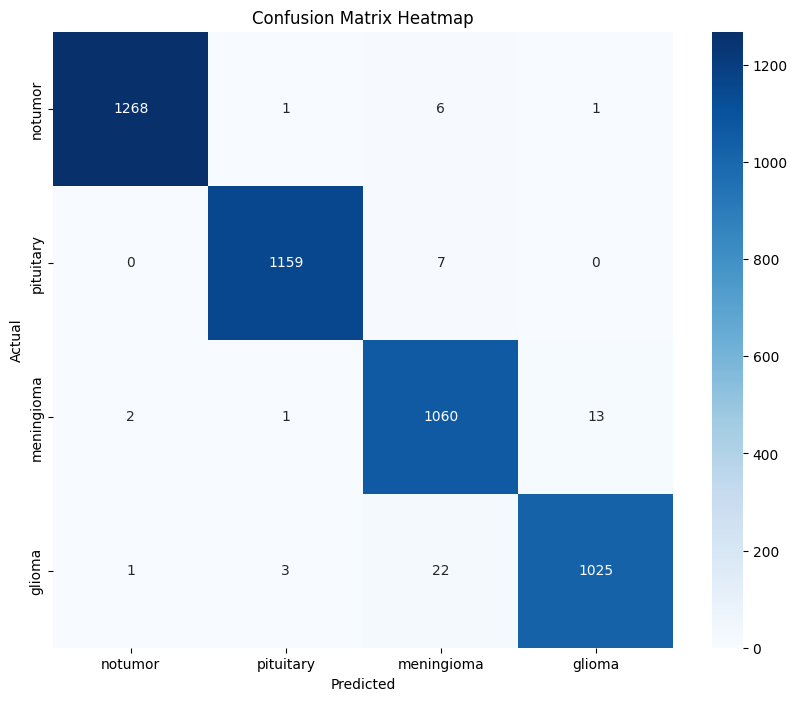

In [11]:
train_confusion_matrix = create_confusion_matrix(train_misclassified_images, train_counts)
plot_confusion_matrix(train_confusion_matrix)

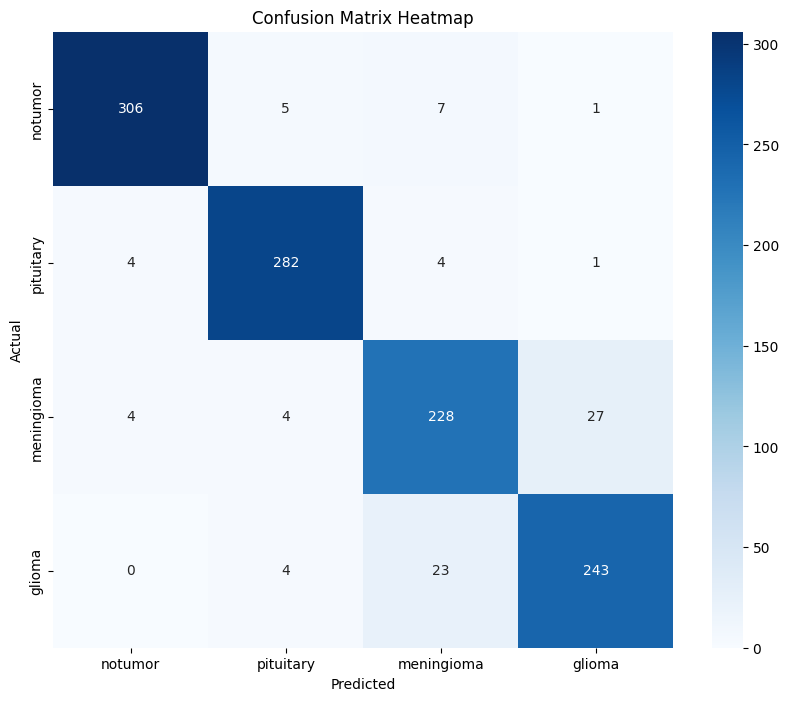

In [12]:
val_confusion_matrix = create_confusion_matrix(val_misclassified_images, val_counts)
plot_confusion_matrix(val_confusion_matrix)